In [1]:
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
import os
import pprint

import tempfile
import pandas as pd
import matplotlib.pyplot as plt

import ast
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../")
from scripts.helper import pred_out,decod
import inspect

In [2]:
# lines =  inspect.getsource(pred_out)
# print(lines)

### Loading data

In [3]:
p = '../data/1_Output/train_set.parquet'
df_f = pd.read_parquet(p)
df_f = df_f.rename_axis(None)

In [4]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 0 to 1473
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cis_no               535 non-null    object 
 1   revenue              535 non-null    float64
 2   Products             535 non-null    object 
 3   credit_rating        535 non-null    float64
 4   combined_activities  535 non-null    object 
 5   kyc_turnover         535 non-null    float64
 6   business             535 non-null    object 
dtypes: float64(3), object(4)
memory usage: 33.4+ KB


In [5]:
df_f.rename({'kyc_turnover': 'turnover'}, inplace=True, axis=1)

### Data Preprocessing

In [6]:
# unique_revenue = pd.DataFrame(df_f['revenue'].unique(),columns=["revenue"])
unique_revenue = pd.DataFrame(df_f['turnover'].unique(),columns=["turnover"])
tf_unique_revenue = tf.data.Dataset.from_tensor_slices(dict(unique_revenue))

In [7]:
unique_products = pd.DataFrame(df_f['Products'].unique(),columns=["Products"])
unique_users = pd.DataFrame(df_f['cis_no'].unique(),columns=["cis_no"])
unique_business = pd.DataFrame(df_f['business'].unique(),columns=["business"])
tf_data = tf.data.Dataset.from_tensor_slices(dict(df_f))
tf_unique_products = tf.data.Dataset.from_tensor_slices(dict(unique_products))
tf_unique_users = tf.data.Dataset.from_tensor_slices(dict(unique_users))
tf_unique_business = tf.data.Dataset.from_tensor_slices(dict(unique_business))

In [8]:
interactions = tf_data.map(lambda x: {
    'cis_no' : x['cis_no'],
    'Products' : x['Products'],
    'turnover' : float(x['turnover']),
    'business' : x['business']
})

# items = tf_products.map(lambda x: x['Products'])
# industry = tf_industry.map(lambda x:x['industry'])
items = tf_unique_products.map(lambda x: x['Products'])
business = tf_unique_business.map(lambda x:x['business'])

In [9]:
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(tf_unique_users.map(lambda x:x["cis_no"]))

product_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
product_titles_vocabulary.adapt(items)

business_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
business_vocabulary.adapt(business)

In [10]:
revenue_vocabulary = tf.keras.layers.IntegerLookup(mask_token=None)
revenue_vocabulary.adapt(tf_unique_revenue.map(lambda x:x["turnover"]))

### Model development

In [11]:
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        max_tokens = 10_000

        # customer id
        self.user_embedding = tf.keras.Sequential([
            user_ids_vocabulary,
            tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(),64)
            ])

        # business
        self.business_embedding = tf.keras.Sequential([
            business_vocabulary,
            tf.keras.layers.Embedding(business_vocabulary.vocabulary_size(),64)
            ])

        # self.business_vectorizer =  tf.keras.layers.TextVectorization(
        #     max_tokens=max_tokens)
        # self.business_text_embedding = tf.keras.Sequential([
        # self.business_vectorizer,
        # tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
        # tf.keras.layers.GlobalAveragePooling1D(),
        # ])

        # self.business_vectorizer.adapt(business)
        
        #revenue embedding
        self.revenue_embedding = tf.keras.Sequential([
            revenue_vocabulary,
            tf.keras.layers.Embedding(revenue_vocabulary.vocabulary_size(),64)
            ])

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat([
            self.user_embedding(inputs["cis_no"]),
            self.business_embedding(inputs["business"]),
            # self.business_text_embedding(inputs["business"]),
            self.revenue_embedding(inputs["turnover"]),
            ], axis=1)

In [12]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""
    def __init__(self, layer_sizes):
        """Model for encoding user queries.
        Args:
        layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()
        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()
        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()
        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [13]:
class ProductModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        max_tokens = 10_000

        self.title_embedding = tf.keras.Sequential([
            product_titles_vocabulary,
            tf.keras.layers.Embedding(product_titles_vocabulary.vocabulary_size(),64)
            ])
        
        # self.title_vectorizer = tf.keras.layers.TextVectorization(
        #     max_tokens=max_tokens)
        # self.title_text_embedding = tf.keras.Sequential([
        # self.title_vectorizer,
        # tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
        # tf.keras.layers.GlobalAveragePooling1D(),
        # ])
        # self.title_vectorizer.adapt(items)
    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            # self.title_text_embedding(titles),
        ], axis=1)

In [14]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""
    def __init__(self, layer_sizes):
        """Model for encoding movies.
        Args:
            layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()
        self.embedding_model = ProductModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
            
    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [15]:
class IslamicRecModel(tfrs.models.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=items.batch(128).map(self.candidate_model),
            ),
        )
    def compute_loss(self, features, training=False):
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        query_embeddings = self.query_model({
            "cis_no": features["cis_no"],
            "business": features["business"],
            "turnover": features["turnover"]
        })
        islamic_embeddings = self.candidate_model(features["Products"])
        return self.task(
            query_embeddings, islamic_embeddings)

### TRaining the model

In [16]:
tf.random.set_seed(42)
shuffled = interactions.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(90_000)
test = shuffled.skip(90_000).take(10_000)
cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [27]:
model = IslamicRecModel([32])
# model = IslamicRecModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.8))

In [38]:
one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=30,
    verbose=0)

In [29]:
one_layer_history.history.keys()

dict_keys(['factorized_top_k/top_1_categorical_accuracy', 'factorized_top_k/top_5_categorical_accuracy', 'factorized_top_k/top_10_categorical_accuracy', 'factorized_top_k/top_50_categorical_accuracy', 'factorized_top_k/top_100_categorical_accuracy', 'loss', 'regularization_loss', 'total_loss'])

dict_keys(['factorized_top_k/top_1_categorical_accuracy', 'factorized_top_k/top_5_categorical_accuracy', 'factorized_top_k/top_10_categorical_accuracy', 'factorized_top_k/top_50_categorical_accuracy', 'factorized_top_k/top_100_categorical_accuracy', 'loss', 'regularization_loss', 'total_loss'])


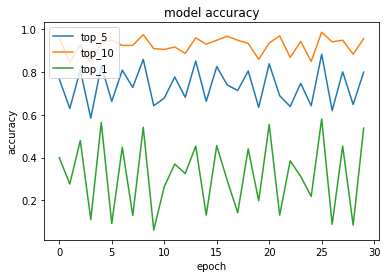

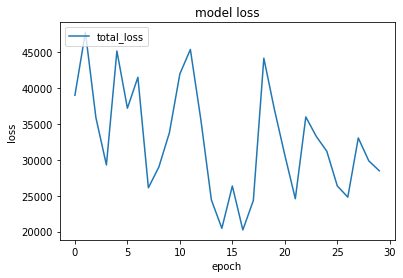

In [46]:
%matplotlib inline
# list all data in history

print(one_layer_history.history.keys())

# summarize history for accuracy

plt.plot(one_layer_history.history['factorized_top_k/top_5_categorical_accuracy'])

plt.plot(one_layer_history.history['factorized_top_k/top_10_categorical_accuracy'])

plt.plot(one_layer_history.history['factorized_top_k/top_1_categorical_accuracy'])


plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['top_5', 'top_10', 'top_1'], loc='upper left')

plt.show()

# summarize history for loss

# plt.plot(one_layer_history.history['loss'])

plt.plot(one_layer_history.history['total_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['total_loss'], loc='upper left')

plt.show()

In [30]:
print(one_layer_history.history['factorized_top_k/top_5_categorical_accuracy'][-1])

0.6112149357795715


### Prediction

In [22]:
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model,k=5)
index.index_from_dataset(items.batch(100).map(lambda title: (title,model.candidate_model(title))))

In [23]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 0 to 1473
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cis_no               535 non-null    object 
 1   revenue              535 non-null    float64
 2   Products             535 non-null    object 
 3   credit_rating        535 non-null    float64
 4   combined_activities  535 non-null    object 
 5   turnover             535 non-null    float64
 6   business             535 non-null    object 
dtypes: float64(3), object(4)
memory usage: 33.4+ KB


In [24]:
# df_1 = df_f.groupby('cis_no')['revenue'].sum().reset_index()
df_1 = df_f.groupby('cis_no')['turnover'].mean().reset_index()
df_2 = df_f.groupby(['cis_no', 'business'])['business'].count().reset_index(name='Count_t')
df_3 = pd.merge(df_1, df_2, left_on =['cis_no'], right_on=['cis_no'], how='left')
df_4 = pd.merge(df_3, df_f[['cis_no', 'credit_rating']], left_on =['cis_no'], right_on=['cis_no'], how='left').drop_duplicates(['cis_no'])
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 0 to 532
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cis_no         151 non-null    object 
 1   turnover       151 non-null    float64
 2   business       151 non-null    object 
 3   Count_t        151 non-null    int64  
 4   credit_rating  151 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 7.1+ KB


In [25]:
df_rr_1 = pred_out(df_4, index)

In [26]:
df_rr_1.head()

,product,cis_no,turnover,business,credit_rating
0,"[letter_of_guarantee_revenue, deposits_revenue...",010016287,0.000000e+00,Real Estate,22.0
1,"[deposits_revenue, core_payments_float_revenue...",010060109,1.000000e+09,Investment in Commercial Enterprises & Managem...,22.0
2,"[letter_of_guarantee_revenue, syndication_reve...",010160463,1.000000e+08,Building Maintenance Leasing and Management of...,13.0
3,"[recoveries_tt_fee_revenue, matrix_mbol_fee_re...",010200956,1.150000e+08,Metallic Caps & Lids Manufacturing Metallic Ca...,22.0
4,"[loan_nii, core_payments_float_revenue, cash_m...",010239120,7.000000e+09,Transport,15.0


### Import Model Output

In [27]:
import datetime

In [28]:
new_path =  r'../data/2_Model_Out'
if not os.path.exists(new_path):
    os.makedirs(new_path)

In [29]:
dir  =  '../data/2_Model_Out'
path = os.path.join(dir,'Model_Out_'+datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')+'.csv')
print(path)
df_rr_1.to_csv(path, index=False)

../data/2_Model_Out/Model_Out_2022-04-04_15-06.csv


In [30]:
df_rr_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product        151 non-null    object 
 1   cis_no         151 non-null    object 
 2   turnover       151 non-null    float64
 3   business       151 non-null    object 
 4   credit_rating  151 non-null    float64
dtypes: float64(2), object(3)
memory usage: 6.0+ KB


### Validation

In [31]:
p = '../data/1_Output/val_actual.parquet'
val_actual = pd.read_parquet(p)
val_actual = val_actual.rename_axis(None)
val_actual.rename({'kyc_turnover': 'turnover'}, inplace=True, axis=1)

In [32]:
# val_actual = val_actual[['cis_no', 'revenue', 'business', 'credit_rating']]

#### Importing test file

In [33]:
p_1 = '../data/1_Output/val_to_test.parquet'
test_1 = pd.read_parquet(p_1)
test_1 = test_1.rename_axis(None)

In [34]:
test_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 25
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cis_no         26 non-null     object 
 1   kyc_turnover   26 non-null     float64
 2   business       26 non-null     object 
 3   product        26 non-null     object 
 4   credit_rating  26 non-null     float64
 5   count          26 non-null     int64  
 6   group_c        26 non-null     object 
 7   left_out       26 non-null     object 
 8   left_count     26 non-null     int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ KB


In [35]:
test_1.rename({'kyc_turnover': 'turnover'}, inplace=True, axis=1)

In [36]:
to_val = pred_out(test_1,index)

In [37]:
to_val.head()

,product,cis_no,turnover,business,credit_rating
0,"[real_estate_revenue, factoring_nonlrd_revenue...",010254621,1000000.0,"Gifts Trading Handling, Loading & Lifting Equi...",22.0
1,"[deposits_revenue, letter_of_guarantee_revenue...",010259771,70000000.0,New Motor Vehicles Trading Used Automobile Tra...,22.0
2,"[core_payments_float_revenue, recoveries_tt_fe...",010387842,25000000.0,Real Estate Buying & Selling Brokerage,22.0
3,"[syndication_revenue, letter_of_guarantee_reve...",010571453,20000000.0,Commercial Agencies Electrical & Electronic Ap...,17.0
4,"[core_payments_float_revenue, loan_nii, export...",010686050,5000000.0,Ships & Boats Repairing Ships & Boats Maintena...,22.0


In [38]:
def decode(x):
    return x.decode()
val_actual['product'] = val_actual['grouped'].apply(decode)

In [39]:
val_actual.head()

,cis_no,turnover,business,Count_t,credit_rating,grouped,count,product
0,010254621,1000000.0,"Gifts Trading Handling, Loading & Lifting Equi...",2,22.0,"b'[""core_payments_float_revenue"", ""loan_nii""]'",2,"[""core_payments_float_revenue"", ""loan_nii""]"
1,010259771,70000000.0,New Motor Vehicles Trading Used Automobile Tra...,4,22.0,"b'[""core_payments_float_revenue"", ""recoveries_...",4,"[""core_payments_float_revenue"", ""recoveries_tt..."
2,010387842,25000000.0,Real Estate Buying & Selling Brokerage,2,22.0,"b'[""core_payments_float_revenue"", ""loan_nii""]'",2,"[""core_payments_float_revenue"", ""loan_nii""]"
3,010571453,20000000.0,Commercial Agencies Electrical & Electronic Ap...,3,17.0,"b'[""core_payments_float_revenue"", ""loan_nii"", ...",3,"[""core_payments_float_revenue"", ""loan_nii"", ""l..."
4,010686050,5000000.0,Ships & Boats Repairing Ships & Boats Maintena...,3,22.0,"b'[""core_payments_float_revenue"", ""recoveries_...",3,"[""core_payments_float_revenue"", ""recoveries_tt..."


### Hit Rate

In [40]:
from typing import List

In [41]:
def HitRate(topNPredicted:Dict[str,List], leftOutPredictions:List):
    hits = 0
    total = 0
    # For each left-out rating
    for leftOut in leftOutPredictions:
        userID = leftOut[0]
        leftOutProductID= leftOut[1]
        # Is it in the predicted top 3 for this user?
        hit = False
        for productID  in topNPredicted[userID]:
            if leftOutProductID == productID:
                hit = True
                break
        if (hit) :
            hits += 1

        total += 1
    # Compute overall precision
    return hits/total

In [42]:
preds = {k:v for k,v in zip(to_val['cis_no'].tolist(), to_val['product'].tolist())}
actual = test_1[['cis_no','left_out']].values.tolist()

In [43]:
# preds = {k:v for k,v in zip(rec_df['customer_identification'].tolist(),rec_df['recommendation'].tolist())}
# actual = test_1[['cis_no','left_out']].values.tolist()
hit_rate = HitRate(preds,actual)
hit_rate

0.6153846153846154

### Coverage

In [44]:
def Coverage(products,predictions):
    total_products  = len(products)
    total_products_predicted =len(set([x for y  in list(predictions.values()) for x in y]))
    return total_products_predicted/total_products


In [45]:
set(df_f['Products'].unique().tolist())

{'cash_management_revenue',
 'core_payments_float_revenue',
 'deposits_revenue',
 'doc_collection_revenue',
 'export_fbp_revenue',
 'factoring_nonlrd_revenue',
 'letter_of_credit_revenue',
 'letter_of_guarantee_revenue',
 'liquidity_management_revenue',
 'loan_nii',
 'matrix_mbol_fee_revenue',
 'real_estate_revenue',
 'recoveries_tt_fee_revenue',
 'syndication_revenue',
 'trust_reciept_revenue'}

In [46]:
p_2 = '../../CLTV_final/main/data/raw_load/islamic_cl_pos_act.parquet'
islamic_cl = pd.read_parquet(p_2)
islamic_cl = islamic_cl.rename_axis(None)

In [47]:
products = set(islamic_cl['NPTB_L1'].unique().tolist())

coverage = Coverage(products,preds)

coverage

1.0

### Novelity

In [48]:
products = islamic_cl[['NPTB_L1']]
product_count = products.groupby('NPTB_L1').size()
popularity = product_count/product_count.max()

In [49]:
def Novelty(popularity,preds):
    pop=[]
    for p in list(preds.values()):
        m = popularity.loc[p].mean()
        pop.append(m)
    return np.nanmean(pop)
novelty = Novelty(popularity,preds)
novelty

0.331337627889352

<AxesSubplot:xlabel='NPTB_L1'>

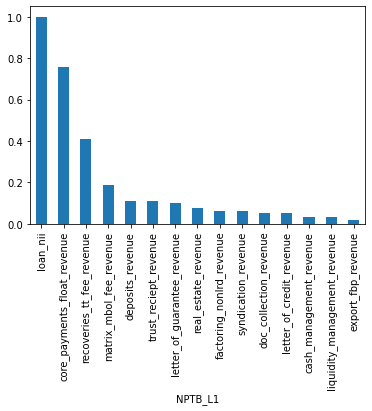

In [50]:
popularity.sort_values(ascending=False).plot(kind='bar')

#### whole data

In [51]:
p_t = '../data/1_Output/train_set_full.parquet'
df_full = pd.read_parquet(p_t)
df_full = df_full.rename_axis(None)

In [52]:
df_full.rename({'kyc_turnover': 'turnover'}, inplace=True, axis=1)

In [53]:
grouped = df_full.groupby('cis_no').aggregate(lambda x: x.unique().tolist()).reset_index()
grouped['grouped'] = grouped['Products']
full_set = grouped.copy()
full_set = full_set[['cis_no','grouped']]

full_set['count'] = full_set['grouped'].apply(lambda x: len(x))
pd.options.display.max_rows=None

df_ts_1 = df_full.groupby('cis_no')['turnover'].mean().reset_index()
df_ts_2 = df_full.groupby(['cis_no', 'business'])['business'].count().reset_index(name='Count_t')
df_ts_3 = pd.merge(df_ts_1, df_ts_2, left_on =['cis_no'], right_on=['cis_no'], how='left')
df_ts_4 = pd.merge(df_ts_3, df_full[['cis_no', 'credit_rating']], left_on =['cis_no'], right_on=['cis_no'], how='left').drop_duplicates(['cis_no'])


full_set_1 = pd.merge(df_ts_4, full_set, left_on =['cis_no'], right_on=['cis_no'], how='left').drop_duplicates(['cis_no'])


In [54]:
full_set_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 0 to 176
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cis_no         177 non-null    object 
 1   turnover       177 non-null    float64
 2   business       177 non-null    object 
 3   Count_t        177 non-null    int64  
 4   credit_rating  177 non-null    float64
 5   grouped        177 non-null    object 
 6   count          177 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 11.1+ KB


### Prediction

In [56]:
final_pred = pred_out(full_set_1,index)
# final_pred

In [57]:
p = '../data/4_Report/final_pred.parquet'
final_pred.to_parquet(p, engine='fastparquet')

In [58]:
final_pred.head()

,product,cis_no,turnover,business,credit_rating
0,"[letter_of_guarantee_revenue, deposits_revenue...",010016287,0.000000e+00,Real Estate,22.0
1,"[deposits_revenue, core_payments_float_revenue...",010060109,1.000000e+09,Investment in Commercial Enterprises & Managem...,22.0
2,"[letter_of_guarantee_revenue, syndication_reve...",010160463,1.000000e+08,Building Maintenance Leasing and Management of...,13.0
3,"[recoveries_tt_fee_revenue, matrix_mbol_fee_re...",010200956,1.150000e+08,Metallic Caps & Lids Manufacturing Metallic Ca...,22.0
4,"[loan_nii, core_payments_float_revenue, cash_m...",010239120,7.000000e+09,Transport,15.0
